In [1]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
pip install --quiet --upgrade deepface

Note: you may need to restart the kernel to use updated packages.


In [6]:
from pinecone import Pinecone, ServerlessSpec
from sklearn.decomposition import PCA
from deepface import DeepFace
from sklearn.manifold import TSNE
from UDCUtils import UDCUtils

import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import contextlib

In [7]:
utils = UDCUtils()

pinecone_api_key = utils.get_pinecone_api_key()

pinecone_api_key

'fcd3e082-248a-4a31-b1c0-80c255c9d687'

In [9]:
#!wget -q --show-progress -O "images/family_photos.zip" "https://www.dropbox.com/scl/fi/yg0f2ynbzzd2q4nsweti5/family_photos.zip?rlkey=00oeuiii3jgapz2b1bfj0vzys&dl=0"

#!unzip -q images/family_photos.zip images/

In [13]:
def show_img(img):
    l_img = plt.imread(img)
    plt.figure(figsize=[4,4])
    plt.imshow(l_img)

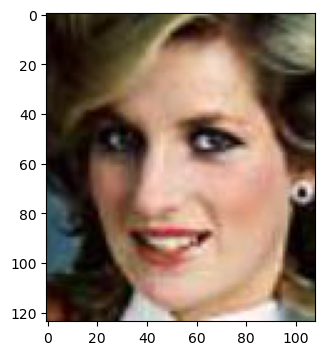

In [14]:
show_img("images/family/mom/P04407_face2.jpg")

## Setup pinecone object

In [15]:
pinecone = Pinecone(api_key=pinecone_api_key)

index_name = utils.create_dlai_index_name("idx-img-")

In [17]:
pinecone.create_index(
    name=index_name,
    spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    metric="cosine",
    dimension=128
)

INDEX = pinecone.Index(index_name)

## Create Embeddings using DeepFace

In [27]:
from tqdm import tqdm
MODEL="Facenet"
def generate_vectors(folder_list:list):
    VECTOR_FILE = "vectors/FACIAL_SEARCH_MONARCHS.vec"

    with contextlib.suppress(FileNotFoundError):
        os.remove(VECTOR_FILE)

    with open(VECTOR_FILE,"x") as f:
        for person in folder_list:
            files = glob.glob(f'images/family/{person}/*')
            for file in tqdm(files):
                try:
                    embedding = DeepFace.represent(img_path=file, model_name=MODEL, enforce_detection=False)[0]['embedding']
                    f.write(f'{person}:{os.path.basename(file)}:{embedding}\n')
                except (ValueError, UnboundLocalError, AttributeError) as e:
                    print(e)


In [28]:
generate_vectors(['dad','mom','child'])

  0%|                                                    | 0/70 [00:00<?, ?it/s]

24-08-21 09:28:24 - facenet_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /Users/sana/.deepface/weights/facenet_weights.h5

  0%|                                               | 0.00/92.2M [00:00<?, ?B/s]
  1%|▏                                      | 524k/92.2M [00:00<00:42, 2.15MB/s]
  1%|▍                                     | 1.05M/92.2M [00:00<00:41, 2.19MB/s]
  2%|▋                                     | 1.57M/92.2M [00:00<00:40, 2.23MB/s]
  2%|▊                                     | 2.10M/92.2M [00:00<00:38, 2.34MB/s]
  3%|█                                     | 2.62M/92.2M [00:01<00:34, 2.59MB/s]
  3%|█▎                                    | 3.15M/92.2M [00:01<00:32, 2.72MB/s]
  4%|█▌                                    | 3.67M/92.2M [00:01<00:34, 2.57MB/s]
  5%|█▋                                    | 4.19M/92.2M [00:01<00:33, 2.62MB/s]
  5%|█▉                                    | 4.72M/92.2M [00:01<00:33, 2.61MB/s]
  6%|██▏                     

In [29]:
!head -5 "vectors/FACIAL_SEARCH_MONARCHS.vec"

dad:P06303_face1.jpg:[-1.178490400314331, -0.45471927523612976, -0.4368080794811249, -0.9187024235725403, -0.7692632079124451, 1.0336494445800781, -0.1469833105802536, -0.22603237628936768, 0.767642617225647, -0.10584451258182526, -0.2562042772769928, 0.8622126579284668, -0.09066053479909897, -0.6638197898864746, -0.293561726808548, 0.9164713621139526, 1.5014408826828003, -1.2569407224655151, 0.11852256953716278, -0.017401741817593575, 1.4135475158691406, 0.9292780756950378, -0.7814769744873047, -0.1569823920726776, 1.7598340511322021, -0.014969199895858765, 0.6338145732879639, 0.8372642397880554, 0.1543702334165573, -0.7940709590911865, -0.8822931051254272, 1.2020645141601562, -0.6975176334381104, 1.7234323024749756, 0.9896595478057861, -1.0452520847320557, -0.13130712509155273, -2.0945024490356445, -0.4507893919944763, -2.390037775039673, -1.4138295650482178, 0.3019157648086548, -1.7080721855163574, -0.2973766326904297, -0.259466290473938, -1.4307643175125122, 0.07039065659046173, -0

## Plot images

In [30]:
def gen_tsne_dataframe(person, perplexity, vector_file):
    vectors=[]
    with open(vector_file,"r") as f:
        lines = f.readlines()
        for line in lines:
            p, orig_img, emb = line.split(":")
            if p==person:
                vectors.append(eval(emb))

    pca = PCA(n_components=8)
    tsne = TSNE(2, perplexity=perplexity, random_state=0, n_iter=1000, verbose=0, metric="euclidean", learning_rate=75)
    print(f"Transforming {len(vectors)} vectors")
    pca_transform_vectors = pca.fit_transform(vectors)
    embeddings2d = tsne.fit_transform(pca_transform_vectors)

    return pd.DataFrame({'x':embeddings2d[:,0],'y':embeddings2d[:,1]})

In [34]:
def plot_tsne(perplexity, model, persons, vector_file):
    (_, ax) = plt.subplots(figsize=(8,5))
    #plt.style.use('seaborn-whitegrid')
    plt.grid(color='#EAEAEB', linewidth=0.5)
    ax.spines['top'].set_color(None)
    ax.spines['right'].set_color(None)
    ax.spines['left'].set_color('#2B2F30')
    ax.spines['bottom'].set_color('#2B2F30')
    colormap = {f'{persons[0]}':'#ee8933', f'{persons[1]}':'#4fad5b', f'{persons[2]}':'#4c93db'}

    for person in colormap:
        embeddingsdf = gen_tsne_dataframe(person, perplexity, vector_file)
        ax.scatter(embeddingsdf.x, embeddingsdf.y, alpha=.5, 
                   label=person, color=colormap[person])
    plt.title(f'Scatter plot of faces using {model}', fontsize=16, fontweight='bold', pad=20)
    plt.suptitle(f't-SNE [perplexity={perplexity}]', y=0.92, fontsize=13)
    plt.legend(loc='best', frameon=True)
    plt.show()

Transforming 70 vectors
Transforming 93 vectors
Transforming 78 vectors


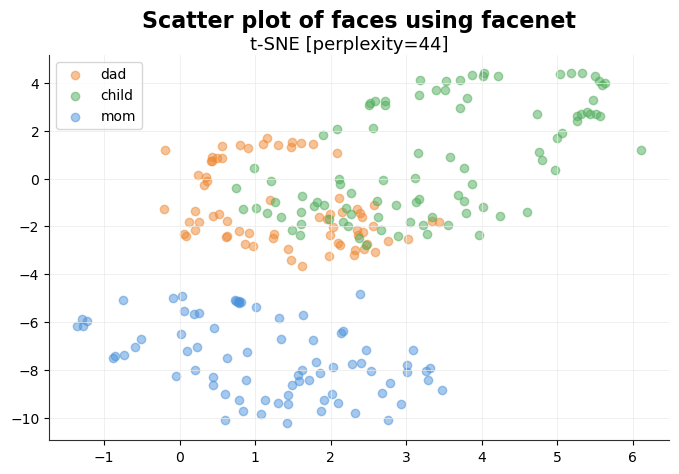

In [35]:
plot_tsne(44, 'facenet', persons=['dad','child','mom'], vector_file="vectors/FACIAL_SEARCH_MONARCHS.vec")

## Upsert vectors to pinecone

In [79]:
INDEX.delete(delete_all=True, namespace='')

{}

In [81]:
vector_file="vectors/FACIAL_SEARCH_MONARCHS.vec"
prepped=[]
cnt=0
with open(vector_file, "r") as f:
    for line in tqdm(f):
        cnt = cnt + 1
        person, imgfile, embeddings = line.split(":")
        prepped.append(
            {'id':f'{person}-{cnt}',
            'values':eval(embeddings),
            'metadata':{'person':person, 'file':imgfile}}
        )
        INDEX.upsert(prepped)
        #INDEX.upsert([(f'{person}-{imgfile}', eval(embeddings), {'person':person, 'file':imgfile})])

241it [01:37,  2.46it/s]


In [82]:
prepped.clear()

In [83]:
print(cnt)

241


In [84]:
INDEX.describe_index_stats()

{'dimension': 128,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 329}},
 'total_vector_count': 329}

In [90]:
val = INDEX.fetch(ids=['dad-1'])
print(val.to_dict())

{'vectors': {'dad-1': {'id': 'dad-1', 'values': [-1.1784904, -0.454719275, -0.436808079, -0.918702424, -0.769263208, 1.03364944, -0.146983311, -0.226032376, 0.767642617, -0.105844513, -0.256204277, 0.862212658, -0.0906605348, -0.66381979, -0.293561727, 0.916471362, 1.50144088, -1.25694072, 0.11852257, -0.0174017418, 1.41354752, 0.929278076, -0.781477, -0.156982392, 1.75983405, -0.0149692, 0.633814573, 0.83726424, 0.154370233, -0.794070959, -0.882293105, 1.20206451, -0.697517633, 1.7234323, 0.989659548, -1.04525208, -0.131307125, -2.09450245, -0.450789392, -2.39003778, -1.41382957, 0.301915765, -1.70807219, -0.297376633, -0.25946629, -1.43076432, 0.0703906566, -0.608553529, -0.163810477, 1.86791074, -1.26925576, -0.452818573, -0.202057868, -0.225373164, -0.132652223, -0.721073031, 1.16534567, -0.487507164, -1.32795703, -1.21424973, -1.47157788, -0.257217914, 1.738446, 1.43124568, 0.370684803, 0.0717497915, 0.432861805, -0.146912813, 0.528873265, -1.38407278, 0.7659446, -1.23869061, -0.8

In [94]:
#test which of the parent resembles most to the child 
def compute_match_scores(vec_groups, parent, child):
    index = pinecone.Index(index_name)
    parent_vecs = vec_groups[parent]
    print(len(parent_vecs))
    K=10
    SAMPLE_SIZE=10
    sum=0

    for i in tqdm(range(0, SAMPLE_SIZE)):
        print(type(parent_vecs[i]))
        print(f'{child}{type(child)}')
        response = index.query(
            vector=parent_vecs[i],
            filter={
                "person":{"$eq": child}
            },
            top_k=K,
            include_metadata=True
        )
    for r in response["matches"]:
        sum = sum + r["score"]
    print(f"Average match score for {parent} is {sum/(SAMPLE_SIZE*K)}")

In [97]:
def test():
    vector_grps = {"dad":[], "mom":[], "child":[]}
    with open(vector_file, "r") as f:
        for line in tqdm(f):
            person, imgfile, emb = line.split(":")
            vector_grps[person].append(eval(emb))

    print(f"DAD \n{'-' * 20}")
    compute_match_scores(vector_grps, "dad", "child")
    print(f"MOM \n{'-' * 20}")
    compute_match_scores(vector_grps, "mom", "child")

In [98]:
test()

241it [00:00, 3053.79it/s]


DAD 
--------------------
70


  0%|                                                    | 0/10 [00:00<?, ?it/s]

<class 'list'>
child<class 'str'>


 10%|████▍                                       | 1/10 [00:00<00:07,  1.17it/s]

<class 'list'>
child<class 'str'>


 20%|████████▊                                   | 2/10 [00:01<00:03,  2.08it/s]

<class 'list'>
child<class 'str'>


 30%|█████████████▏                              | 3/10 [00:01<00:02,  2.74it/s]

<class 'list'>
child<class 'str'>


 40%|█████████████████▌                          | 4/10 [00:01<00:01,  3.26it/s]

<class 'list'>
child<class 'str'>


 50%|██████████████████████                      | 5/10 [00:01<00:01,  3.61it/s]

<class 'list'>
child<class 'str'>


 60%|██████████████████████████▍                 | 6/10 [00:01<00:01,  3.89it/s]

<class 'list'>
child<class 'str'>


 70%|██████████████████████████████▊             | 7/10 [00:02<00:00,  4.07it/s]

<class 'list'>
child<class 'str'>


 80%|███████████████████████████████████▏        | 8/10 [00:02<00:00,  4.13it/s]

<class 'list'>
child<class 'str'>


 90%|███████████████████████████████████████▌    | 9/10 [00:02<00:00,  3.95it/s]

<class 'list'>
child<class 'str'>


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  3.33it/s]


Average match score for dad is 0.04033446876999999
MOM 
--------------------
78


  0%|                                                    | 0/10 [00:00<?, ?it/s]

<class 'list'>
child<class 'str'>


 10%|████▍                                       | 1/10 [00:00<00:08,  1.07it/s]

<class 'list'>
child<class 'str'>


 20%|████████▊                                   | 2/10 [00:01<00:04,  1.95it/s]

<class 'list'>
child<class 'str'>


 30%|█████████████▏                              | 3/10 [00:01<00:02,  2.64it/s]

<class 'list'>
child<class 'str'>


 40%|█████████████████▌                          | 4/10 [00:01<00:01,  3.17it/s]

<class 'list'>
child<class 'str'>


 50%|██████████████████████                      | 5/10 [00:01<00:01,  3.59it/s]

<class 'list'>
child<class 'str'>


 60%|██████████████████████████▍                 | 6/10 [00:02<00:01,  3.78it/s]

<class 'list'>
child<class 'str'>


 70%|██████████████████████████████▊             | 7/10 [00:02<00:00,  4.01it/s]

<class 'list'>
child<class 'str'>


 80%|███████████████████████████████████▏        | 8/10 [00:02<00:00,  4.14it/s]

<class 'list'>
child<class 'str'>


 90%|███████████████████████████████████████▌    | 9/10 [00:02<00:00,  4.28it/s]

<class 'list'>
child<class 'str'>


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  3.43it/s]

Average match score for mom is 0.02813916056


## Checking the matching images

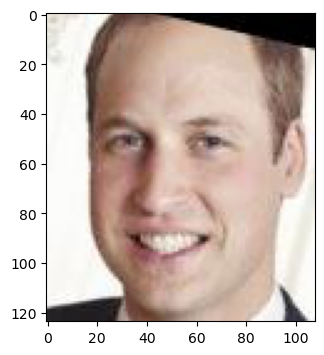

In [100]:
child_base = 'images/family/child/P06310_face1.jpg'
show_img(child_base)

In [102]:
#finding closest image of dad (given the score for dad is greater than mom)
embedding = DeepFace.represent(img_path=child_base, model_name=MODEL)[0]['embedding']
#print(embedding)

response = INDEX.query(
    vector=embedding,
    filter={
        'person':{"$eq":"dad"}
    },
    top_k=10,
    include_metadata=True
)

print(response["matches"])

[{'id': 'dad-34',
 'metadata': {'file': 'P06396_face3.jpg', 'person': 'dad'},
 'score': 0.437432677,
 'values': []}, {'id': 'dad-5',
 'metadata': {'file': 'P11969_face7.jpg', 'person': 'dad'},
 'score': 0.371855289,
 'values': []}, {'id': 'dad-67',
 'metadata': {'file': 'P11910_face1.jpg', 'person': 'dad'},
 'score': 0.363930285,
 'values': []}, {'id': 'dad-12',
 'metadata': {'file': 'P06305_face0.jpg', 'person': 'dad'},
 'score': 0.327961832,
 'values': []}, {'id': 'dad-23',
 'metadata': {'file': 'P06265_face2.jpg', 'person': 'dad'},
 'score': 0.326957911,
 'values': []}, {'id': 'dad-46',
 'metadata': {'file': 'P11991_face7.jpg', 'person': 'dad'},
 'score': 0.325357795,
 'values': []}, {'id': 'dad-44',
 'metadata': {'file': 'P04407_face3.jpg', 'person': 'dad'},
 'score': 0.318417072,
 'values': []}, {'id': 'dad-39',
 'metadata': {'file': 'P11988_face0.jpg', 'person': 'dad'},
 'score': 0.309913188,
 'values': []}, {'id': 'dad-59',
 'metadata': {'file': 'P11886_face3.jpg', 'person': 'da

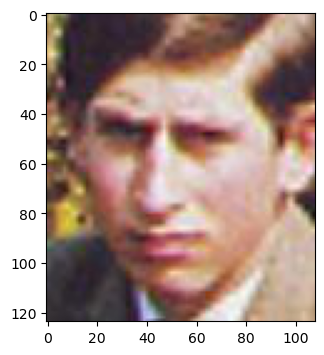

In [106]:
show_img("images/family/dad/"+response["matches"][0]["metadata"]["file"])